# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Eleni Tsaousi, 24-745-119 and eleni.tsaousi@uzh.ch>
<Yiyun Zhou 23-747-702 yiyun.zhou@uzh.ch>
<Jiaqi Zhang 20-740-213 jiaqi.zhang@uzh.ch>

In [8]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = "/Users/elenetsaouse/qpmwp-course"
sys.path.append("/Users/elenetsaouse/qpmwp-course/qpmwp-course/src")
   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [9]:
# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Set seed for reproducibility
np.random.seed(42)

# Generate a random mean vector
mean = np.random.uniform(-0.01, 0.01, N)

# Generate a random covariance matrix (positive semi-definite)
cov = np.random.uniform(0.0001, 0.001, (N, N))
cov = np.dot(cov, cov.T)  # Symmetric positive semi-definite matrix
cov += 1e-4 * np.eye(N)  # Ensure positive definiteness

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

# Convert the dataset to a DataFrame
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Create instances of ExpectedReturn and Covariance
expected_return_estimator = ExpectedReturn()
covariance_estimator = Covariance()

# Compute the vector of expected returns (mean returns)
q = expected_return_estimator.estimate(X=df, inplace=False)

# Compute the covariance matrix
P = covariance_estimator.estimate(X=df, inplace=False)

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)



Vector of expected returns (q):
Asset_1     -0.002128
Asset_2      0.008525
Asset_3      0.004729
Asset_4      0.002331
Asset_5     -0.007227
               ...   
Asset_96    -0.000326
Asset_97     0.000297
Asset_98    -0.001795
Asset_99    -0.009300
Asset_100   -0.008039
Length: 100, dtype: float64

Covariance matrix (P):
            Asset_1   Asset_2   Asset_3   Asset_4   Asset_5   Asset_6  \
Asset_1    0.000145  0.000030  0.000039  0.000045  0.000032  0.000032   
Asset_2    0.000030  0.000145  0.000033  0.000039  0.000032  0.000035   
Asset_3    0.000039  0.000033  0.000144  0.000033  0.000028  0.000020   
Asset_4    0.000045  0.000039  0.000033  0.000141  0.000032  0.000038   
Asset_5    0.000032  0.000032  0.000028  0.000032  0.000135  0.000026   
...             ...       ...       ...       ...       ...       ...   
Asset_96   0.000033  0.000031  0.000034  0.000032  0.000027  0.000028   
Asset_97   0.000033  0.000037  0.000027  0.000035  0.000032  0.000029   
Asset_98   0.0000

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [10]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget()

# Add box constraints 
constraints.add_box(lower=0, upper=0.2)

# Add linear constraints
# Group 1: Sum of weights of the first 30 assets <= 0.3
G1 = pd.Series([1] * 30 + [0] * 70, index=df.columns)
constraints.add_linear(g_values=G1, sense='<=', rhs=0.3, name='Group1')

# Group 2: Sum of weights of assets 31 to 60 <= 0.4
G2 = pd.Series([0] * 30 + [1] * 30 + [0] * 40, index=df.columns)
constraints.add_linear(g_values=G2, sense='<=', rhs=0.4, name='Group2')

# Group 3: Sum of weights of assets 61 to 100 <= 0.5
G3 = pd.Series([0] * 60 + [1] * 40, index=df.columns)
constraints.add_linear(g_values=G3, sense='<=', rhs=0.5, name='Group3')

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [11]:
# Extract constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Get the list of solvers
solvers = list(USABLE_SOLVERS)

# Initialize results DataFrame
results = pd.DataFrame(index=['solution_found', 'objective', 'primal_residual', 'dual_residual', 'duality_gap', 'runtime'], 
                        columns=solvers)

# Variable to store portfolio weights from the first successful solver
previous_weights = None  

for solver in solvers:
    try:
        start_time = timeit.default_timer()
        
        # Instantiate the Quadratic Program
        qp = QuadraticProgram(
            P=P.to_numpy(),
            q=q.to_numpy() * -1,
            G=GhAb['G'],
            h=GhAb['h'],
            A=GhAb['A'],
            b=GhAb['b'],
            lb=constraints.box['lower'].to_numpy(),
            ub=constraints.box['upper'].to_numpy(),
            solver=solver,
        )

        # Solve the optimization problem
        qp.solve()

        # Ensure the solution exists before accessing attributes
        solution = qp.results.get('solution', None)

        end_time = timeit.default_timer()

        if solution is not None:
            results.loc[:, solver] = [
                solution.found, 
                qp.objective_value(),
                solution.primal_residual() if callable(solution.primal_residual) else np.nan,
                solution.dual_residual() if callable(solution.dual_residual) else np.nan,
                solution.duality_gap()[0] if isinstance(solution.duality_gap(), list) else solution.duality_gap(),
                end_time - start_time
            ]
            
            # Store portfolio weights from the first successful solver
            if previous_weights is None:
                previous_weights = solution.x  # Store weights
            
    except Exception as e:
        # If solver fails, store NaNs
        results.loc[:, solver] = [False, np.nan, np.nan, np.nan, np.nan, np.nan]
        print(f"Solver {solver} failed: {e}")

# Convert previous_weights to NumPy array for consistency
if previous_weights is not None:
    previous_weights = np.array(previous_weights)
else:
    print("Warning: No valid solution found for previous_weights.")



Print and visualize the results

                                   qpalm                      daqp  \
solution_found                      True                      True   
objective                      -0.009108                 -0.009107   
primal_residual                 0.000013                       0.0   
dual_residual                        0.0                       0.0   
duality_gap      [7.566506520216044e-07]  [4.2956090073875686e-16]   
runtime                          0.02402                  0.021679   

                                quadprog                   cvxopt  \
solution_found                      True                     True   
objective                      -0.009107                -0.009107   
primal_residual                      0.0                      0.0   
dual_residual                        0.0                      0.0   
duality_gap      [4.839878497975292e-16]  [3.291750025119153e-08]   
runtime                         0.013932                 0.197142   

                         

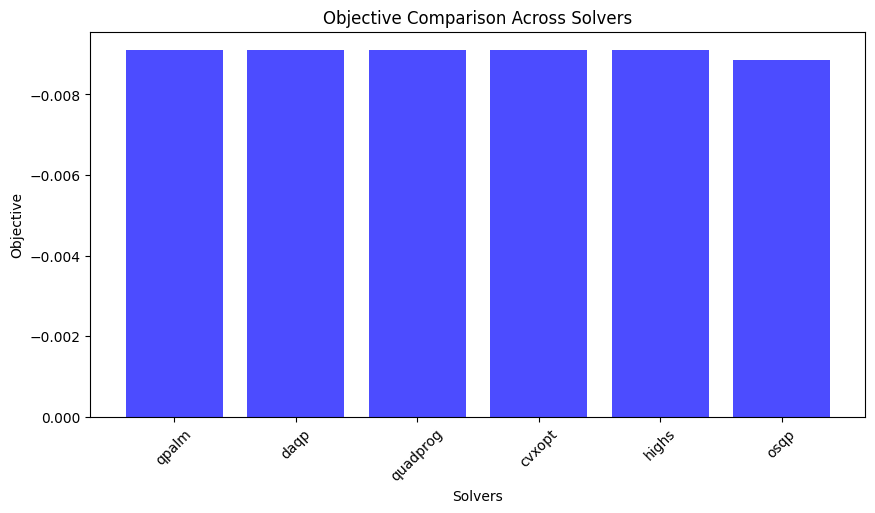

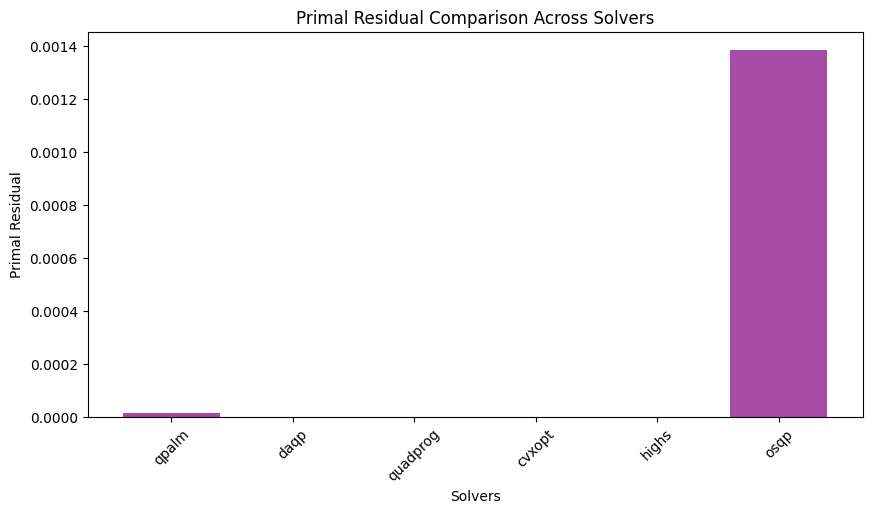

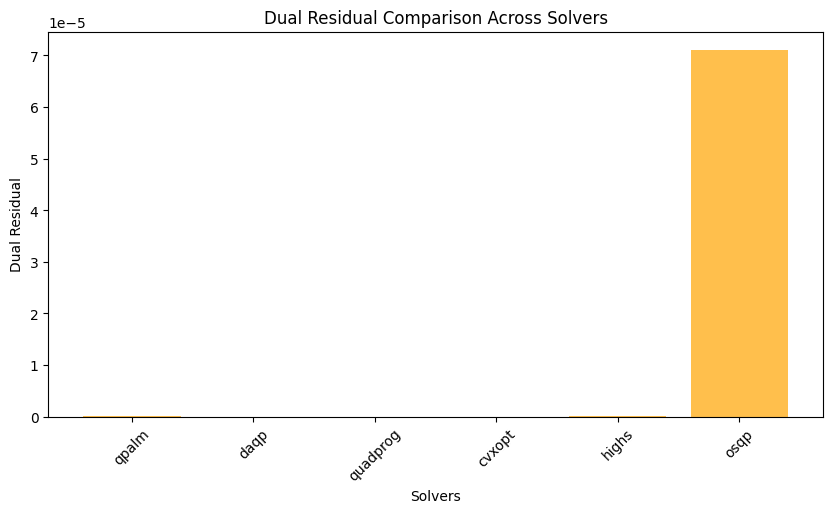

Skipping duality_gap: No valid data to plot


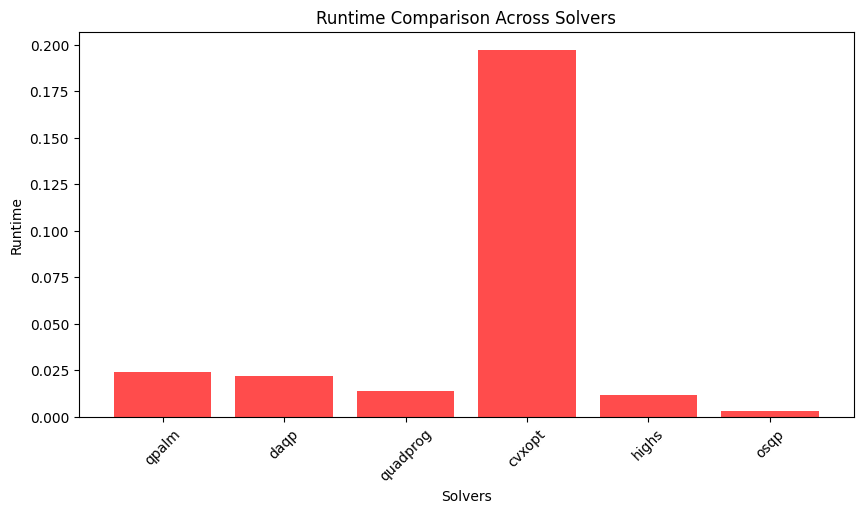

In [12]:
# Display the DataFrame
print(results)

# Transpose results to ensure correct structure
df_results = results.T.apply(pd.to_numeric, errors='coerce')

# Improved Plotting Function
def plot_bar_chart(metric_name, color, ylabel, title):
    if metric_name not in df_results.columns:
        print(f"Skipping {metric_name}: Not found in DataFrame")
        return
    
    # Convert list-like values to scalars
    valid_data = df_results[metric_name].dropna().apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) == 1 else x)

    if valid_data.empty:
        print(f"Skipping {metric_name}: No valid data to plot")
        return

    plt.figure(figsize=(10, 5))
    plt.bar(valid_data.index, valid_data, color=color, alpha=0.7)

    if valid_data.max() < 0:
        plt.gca().invert_yaxis()

    plt.xlabel("Solvers")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Generate bar charts for each metric
for metric, color in zip(["objective", "primal_residual", "dual_residual", "duality_gap", "runtime"], 
                          ["blue", "purple", "orange", "green", "red"]):
    plot_bar_chart(metric, color, metric.replace("_", " ").title(), f"{metric.replace('_', ' ').title()} Comparison Across Solvers")


## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [13]:
# Define MinVariance Class
class MinVariance(Optimization):

    def __init__(self, constraints: Constraints, covariance: Optional[Covariance] = None, solver_name="analytical", **kwargs):
        """
        Initialize MinVariance optimization.
        """
        super().__init__(constraints=constraints, solver_name=solver_name, **kwargs)
        self.covariance = covariance if covariance is not None else Covariance()
        self.solver_name = solver_name  

    def set_objective(self, optimization_data: OptimizationData) -> None:
        """
        Set the objective function for minimum-variance optimization.
        """
        # Compute covariance matrix
        self.P = self.covariance.estimate(optimization_data.return_series.dropna())  # Ensure no missing values
        
        if self.P is None:
            print("Covariance matrix computation failed, using manual computation...")
            self.P = np.cov(optimization_data.return_series.dropna(), rowvar=False)

        if self.P is None or not isinstance(self.P, np.ndarray):
            raise ValueError("Covariance matrix computation failed. Ensure `estimate()` is working correctly.")

        self.q = np.zeros(self.P.shape[0])  # No return maximization, only variance minimization

    def solve(self) -> None:
        """
        Solve the optimization problem. If solver_name='analytical', use analytical solution.
        Otherwise, fall back to numerical optimization.
        """
        if self.solver_name == 'analytical':  
            try:
                inv_P = np.linalg.pinv(self.P)  # Use pseudo-inverse to avoid singular matrix issues
                ones = np.ones(len(self.q))
                self.solution = np.dot(inv_P, ones) / np.dot(ones, np.dot(inv_P, ones))
            except np.linalg.LinAlgError:
                print("Analytical solution not possible, falling back to numerical optimization.")
                return super().solve()
        else:
            return super().solve()


# Create Constraints Object with Budget Constraint
portfolio_constraints = Constraints(ids=df.columns.tolist())
portfolio_constraints.add_budget(rhs=1.0, sense='=')

# Instantiate MinVariance Object
min_var_optimizer = MinVariance(constraints=portfolio_constraints, covariance=Covariance(), solver_name='analytical')

# Prepare Optimization Data
opt_data = OptimizationData(return_series=df.dropna(axis=0))  # Drop NaNs only along rows, keeping all assets

# Solve the Optimization Problem
min_var_optimizer.set_objective(opt_data)
min_var_optimizer.solve()

# Print Optimized Portfolio Weights
print("\nOptimized Portfolio Weights:")
print(min_var_optimizer.solution)

# Compare Results with Part 1.c
if min_var_optimizer.solution.shape == previous_weights.shape:
    print("\nComparison with Part 1.c Results:")
    print("Absolute Difference in Weights:", np.abs(min_var_optimizer.solution - previous_weights))
else:
    print("Error: Shape mismatch. Ensure weight vectors match in size.")


Covariance matrix computation failed, using manual computation...

Optimized Portfolio Weights:
[-0.00371762  0.00455826  0.01489567 -0.03475224  0.01115166  0.04640088
 -0.02407388  0.02454762  0.0193463  -0.03130037 -0.04863524  0.03506027
  0.02526088 -0.00993871  0.01512956  0.00993177  0.02489518 -0.01277847
  0.03001678  0.01964019  0.00947412  0.02662827  0.02033262 -0.00831417
  0.01109936  0.0008386   0.03840745 -0.00996386 -0.00366477  0.04773762
  0.03249447  0.01842211 -0.02097454 -0.00418258  0.00389985 -0.00990022
 -0.01777615  0.0053115   0.00955623  0.02202023  0.00934236  0.00718169
  0.01967146 -0.02355433  0.02950292 -0.03411047  0.06210847  0.02046018
  0.00448179  0.04655097 -0.0009867  -0.00037774  0.00114041  0.04330462
  0.02239402 -0.03667505  0.02279983  0.00087667  0.02317935  0.0085376
  0.05007229  0.00809178 -0.01186503 -0.00811929  0.00317696  0.00560306
 -0.00272853  0.01277276  0.01141511  0.0291577  -0.00890314  0.02576778
  0.02437013 -0.00120722 -0.0